# IBM stance detection with only arguments

Stance detection of the IBM datasets using only arguments as input to train the model, without considering the main topic of each one

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from autocorrect import Speller
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder

In [2]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

## 1. Import datasets

In [3]:
train_path = '../data/ibm/ibm_train.csv'
test_path = '../data/ibm/ibm_test.csv'

plots_path = '../plots/ibm/'
models_path = '../models/ibm/'

### Training set

In [4]:
train = pd.read_csv(train_path) 

In [5]:
train.head()

,topic,stance,argument,argument_sentiment
0,atheism,CON,the most immoral acts in human history were pe...,-1.0
1,partial birth abortions,PRO,Abortion is considered to be morally wrong,-1.0
2,the monarchy,PRO,The laws of succession are held by some to be ...,-1.0
3,endangered species,PRO,More biologically diverse communities appear t...,1.0
4,the sale of violent video games to minors,PRO,Various games are accused of causing addiction...,-1.0


In [6]:
train['topic'].nunique()

25

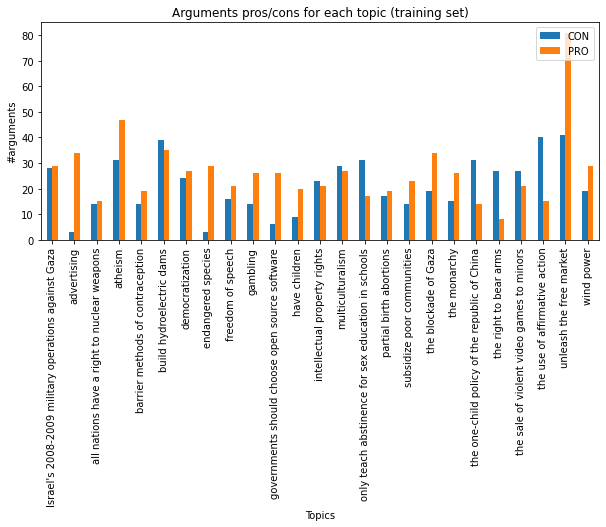

In [7]:
train_stats = train.groupby(by=['topic', 'stance']).agg({'argument': 'count'}).reset_index()
train_stats.pivot(index='topic', columns='stance', values='argument').rename(columns={-1: 'cons', 1: 'pros'}).plot(kind='bar', figsize=(10,4))
plt.title('Arguments pros/cons for each topic (training set)')
plt.ylabel('#arguments')
plt.xlabel('Topics')
plt.xticks(fontsize=10, rotation=90)
plt.legend(loc='upper right')
plt.savefig(plots_path+'ibm_train_topic_stats.png', bbox_inches ="tight")
plt.show()

### Test set

In [8]:
test = pd.read_csv(test_path) 

In [9]:
test.head()

,topic,stance,argument,argument_sentiment
0,intellectual property rights,PRO,"knowledge should be ""shared in solidarity",NaN
1,atheism,PRO,faith − belief that is not based on evidence −...,-1.0
2,build hydroelectric dams,CON,dam construction requires the state to displac...,-1.0
3,the one-child policy of the republic of China,CON,China's gender imbalance is further increased ...,-1.0
4,unleash the free market,CON,laissez-faire capitalism creates social evils ...,-1.0


In [10]:
test['topic'].nunique()

25

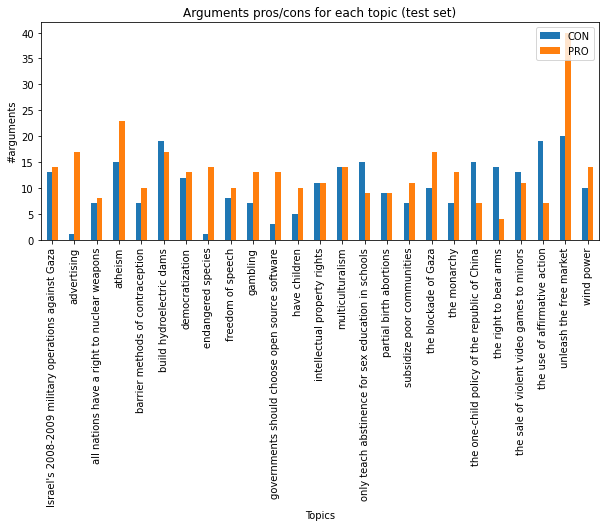

In [11]:
test_stats = test.groupby(by=['topic', 'stance']).agg({'argument': 'count'}).reset_index()
test_stats.pivot(index='topic', columns='stance', values='argument').rename(columns={-1: 'cons', 1: 'pros'}).plot(kind='bar', figsize=(10,4))
plt.title('Arguments pros/cons for each topic (test set)')
plt.ylabel('#arguments')
plt.xlabel('Topics')
plt.xticks(fontsize=10, rotation=90)
plt.legend(loc='upper right')
plt.savefig(plots_path+'ibm_test_topic_stats.png', bbox_inches ="tight")
plt.show()

## 2. Preprocessing data

In [12]:
# lower
# remove extra whitespace
# tokenize
# spelling corrections
# remove stopwords (da verificare se migliora o peggiora)
# remove punctation
# lemmatization
# stemming 
# remove urls
# remove tags

In [13]:
class PreprocessArguments:
    def __init__(self):
        self.spell = Speller(lang='en')
        self.stopwords_set = set(stopwords.words('english'))
        self.punct_remover = RegexpTokenizer(r'\w+')
        self.porter = PorterStemmer()
        self.wnl = WordNetLemmatizer()
    
    def preprocess(self, s):    
        # lowercase
        s = s.lower()
        # remove double whitespaces
        s = ' '.join(s.split())
        # tokenize
        s = word_tokenize(s)
        # spell correction
        s = [self.spell(word) for word in s]
        # remove punctuation
        s = self.punct_remover.tokenize(' '.join(s))
        # remove stopwords
        s = [word for word in s if word not in self.stopwords_set]
        # stemming
        s = [self.porter.stem(word) for word in s]
        #lemmatization
        #s = [self.wnl.lemmatize(word) for word in s]
        
        return s

In [14]:
preproc = PreprocessArguments()

In [15]:
train['arg_tok'] = [preproc.preprocess(row['argument']) for idx, row in train.iterrows()]

In [16]:
test['arg_tok'] = [preproc.preprocess(row['argument']) for idx, row in test.iterrows()]

In [17]:
train.head()

,topic,stance,argument,argument_sentiment,arg_tok
0,atheism,CON,the most immoral acts in human history were pe...,-1.0,"[immor, act, human, histori, perform, atheist]"
1,partial birth abortions,PRO,Abortion is considered to be morally wrong,-1.0,"[abort, consid, moral, wrong]"
2,the monarchy,PRO,The laws of succession are held by some to be ...,-1.0,"[law, success, held, sexist]"
3,endangered species,PRO,More biologically diverse communities appear t...,1.0,"[biolog, divers, commun, appear, stabl]"
4,the sale of violent video games to minors,PRO,Various games are accused of causing addiction...,-1.0,"[variou, game, accus, caus, addict, even, viol..."


In [18]:
count_vect = CountVectorizer(tokenizer=preproc.preprocess, lowercase=False, token_pattern=None)
count_fit = count_vect.fit_transform(train['argument'])

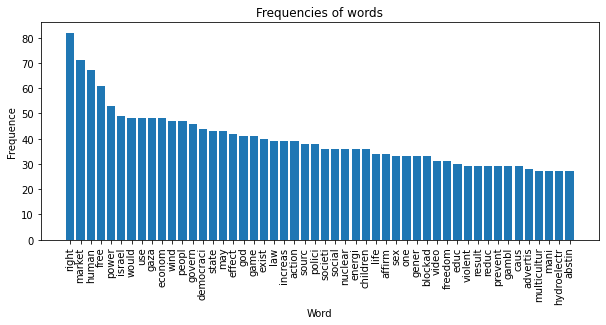

In [19]:
n = 50
count_sum = sorted(list(zip(count_fit.toarray().sum(axis=0), count_vect.get_feature_names_out())), reverse=True)
count_sum = count_sum[:n]
fig, ax = plt.subplots(figsize=(10,4))
plt.bar([p[1] for p in count_sum], [p[0] for p in count_sum])
#plt.bar(range(len(count_sum)), [p[0] for p in count_sum])
plt.title('Frequencies of words')
plt.ylabel('Frequence')
plt.xlabel('Word')
plt.xticks(fontsize=10, rotation=90)
#plt.yticks(np.arange(0,1200,100))
plt.savefig(plots_path+str(n)+'_token_frequencies.png', bbox_inches ="tight")
plt.show()

## 3. Classification

### 3.1 Baseline: Naive Bayes

In [20]:
def dummy_tokenizer(sentence):
    return sentence

In [21]:
lb = LabelBinarizer()
y_train = lb.fit_transform(train['stance'])

In [22]:
scoring = ['accuracy', 'f1', 'precision', 'recall']

In [23]:
pipe = Pipeline([('preproc', TfidfVectorizer()), ('nb', MultinomialNB())])

In [ ]:
params = [
    {'preproc': [TfidfVectorizer()],
     'preproc__tokenizer': [dummy_tokenizer],
     'preproc__preprocessor': [dummy_tokenizer],
     'preproc__token_pattern': [None],
     #'preproc__min_df': [1, 10, 20, 50, 100, 200],
     'preproc__min_df': np.arange(1,11,1),
     #'preproc__max_features': [None, 100, 200, 500],
     'preproc__ngram_range': [(1,1), (1,2), (1,3), (2,3)],
     
     'nb': [MultinomialNB()],
     #'nb__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
     'nb__alpha': np.arange(1,15,1)
    }
]

In [ ]:
clf = GridSearchCV(estimator=pipe, param_grid=params, scoring=scoring, refit='f1',
                   cv=3, return_train_score=True, n_jobs=-2, verbose=10)

In [ ]:
clf.fit(train['arg_tok'], y_train.ravel())

In [ ]:
clf.best_params_

In [ ]:
#pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_f1')[['mean_test_f1', 'param_nb', 'param_preproc__ngram_range', 'param_preproc__min_df']][:600]
#tmp = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_f1')[['mean_test_f1', 'param_nb', 'param_preproc__ngram_range', 'param_preproc__min_df']][:600]
#tmp.groupby(by='param_preproc__min_df').count()


In [ ]:
#pd.DataFrame(clf.cv_results_).to_csv(models_path+'nb_gridsearch.csv')

In [ ]:
best_clf = clf.best_estimator_
best_clf.fit(train['arg_tok'], y_train.ravel())
pred_test = best_clf.predict(test['arg_tok'])
y_test = lb.transform(test['stance'])

In [ ]:
cm = confusion_matrix(y_test, pred_test)
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.inverse_transform(clf.classes_)).plot(ax=ax)
plt.savefig(plots_path+'nb_cm.png', bbox_inches ="tight")

In [ ]:
print(classification_report(y_test, pred_test))

### 3.2 SVM

In [24]:
def dummy_tokenizer(sentence):
    return sentence

In [25]:
scoring = ['accuracy', 'f1', 'precision', 'recall']

In [26]:
pipe = Pipeline([('preproc', TfidfVectorizer()), ('svm', SVC())])

In [84]:
params = [
    {'preproc': [TfidfVectorizer()],
     'preproc__tokenizer': [dummy_tokenizer],
     'preproc__preprocessor': [dummy_tokenizer],
     'preproc__token_pattern': [None],
     #'preproc__min_df': [1, 10, 20, 50, 100],
     #'preproc__min_df': np.arange(1,11,1),
     'preproc__min_df': np.arange(1,6,1),
     #'preproc__max_features': [None, 100, 200, 300, 400, 500, 600],
     'preproc__max_features': [None],
     #'preproc__ngram_range': [(1,1), (1,2), (1,3), (2,3)],
     'preproc__ngram_range': [(1,1), (1,2), (1,3)],
     
     'svm': [SVC()],
     #'svm__C': [0.1, 1, 2, 5, 10, 50],
     #'svm__C': np.arange(1,10,1),
     'svm__C': np.arange(0.01,5,0.5),
     #'svm__C': [1, 5, 10],
     'svm__kernel': ['poly'],
     #'svm__degree': [2, 3, 5, 8, 10],
     'svm__degree': np.arange(2,10,1),
     'svm__gamma': ['scale'],
     #'svm__shrinking': [True, False],     
    },
    
    #{'preproc': [TfidfVectorizer()],
     #'preproc__tokenizer': [dummy_tokenizer],
     #'preproc__preprocessor': [dummy_tokenizer],
     #'preproc__token_pattern': [None],
     #'preproc__min_df': [1, 10, 20, 50, 100],
     #'preproc__min_df': np.arange(1,11,1),
     #'preproc__max_features': [None, 100, 200, 300, 400, 500, 600],
     #'preproc__ngram_range': [(1,1), (1,2), (1,3), (2,3)],
     #'preproc__ngram_range': [(1,1), (1,2), (1,3)],
     
     #'svm': [SVC()],
     #'svm__C': [0.1, 1, 2, 5, 10, 50],
     #'svm__C': np.arange(1,20,2),
     #'svm__C': [1, 5, 10],
     #'svm__kernel': ['rbf', 'sigmoid'],
     #'svm__kernel': ['rbf'],
     #'svm__gamma': ['scale'],
     #'svm__shrinking': [True, False],     
    #},
]

In [85]:
clf = GridSearchCV(estimator=pipe, param_grid=params, scoring=scoring, refit='f1',
                   cv=3, return_train_score=True, n_jobs=-2, verbose=10)

In [ ]:
clf.fit(train['arg_tok'], y_train.ravel())

In [87]:
clf.best_params_

{'preproc': TfidfVectorizer(preprocessor=<function dummy_tokenizer at 0x13d08acb0>,
                 token_pattern=None,
                 tokenizer=<function dummy_tokenizer at 0x13d08acb0>),
 'preproc__max_features': None,
 'preproc__min_df': 1,
 'preproc__ngram_range': (1, 1),
 'preproc__preprocessor': <function __main__.dummy_tokenizer(sentence)>,
 'preproc__token_pattern': None,
 'preproc__tokenizer': <function __main__.dummy_tokenizer(sentence)>,
 'svm': SVC(C=3.01, kernel='poly'),
 'svm__C': 3.01,
 'svm__degree': 3,
 'svm__gamma': 'scale',
 'svm__kernel': 'poly'}

In [88]:
#pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_f1')[['mean_test_f1', 'param_svm__kernel', 'param_preproc__ngram_range', 'param_preproc__min_df']][:100]
#tmp = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_f1')[['mean_test_f1', 'param_svm__kernel', 'param_svm__degree', 'param_svm__C', 'param_preproc__min_df']][:400]
#tmp.groupby(by=['param_svm__kernel', 'param_preproc__min_df']).count()


In [89]:
#pd.DataFrame(clf.cv_results_).to_csv(models_path+'svc_gridsearch.csv')

In [90]:
best_clf = clf.best_estimator_
best_clf.fit(train['arg_tok'], y_train.ravel())
pred_test = best_clf.predict(test['arg_tok'])
y_test = lb.transform(test['stance'])

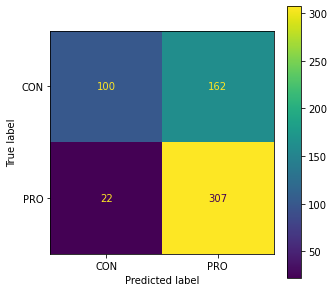

In [91]:
cm = confusion_matrix(y_test, pred_test)
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.inverse_transform(clf.classes_)).plot(ax=ax)
plt.savefig(plots_path+'svc_cm.png', bbox_inches ="tight")

In [92]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.82      0.38      0.52       262
           1       0.65      0.93      0.77       329

    accuracy                           0.69       591
   macro avg       0.74      0.66      0.65       591
weighted avg       0.73      0.69      0.66       591



### 3.3 BERT